# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

# Part 1: Get the data

Skip this part if you load stored numpy arrays (Mirai*.npy) (which is recommended)

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

In [1]:
import numpy as np
from google.colab import drive 
drive.mount('/content/drive',force_remount=True)
x_data = np.load("/content/drive/My Drive/test/Mirai_data_quarter.npy")
y_data = np.load("/content/drive/My Drive/test/Mirai_labels_quarter.npy")
# print(data)

Mounted at /content/drive


# Part 2: Get a graphics card

Skip this part if you run on the CPU

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [2]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

In [3]:
! /opt/bin/nvidia-smi

Thu Apr 29 16:27:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!cat /proc/cpuinfo
!cat /proc/meminfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

# Part 3: Hardware

Skip questions 1, 2, 3, 5, 6 if you use your own computer.

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on.

Question 1: What graphics card is available in the cloud machine? Run 'nvidia-smi' in the terminal. 

1.Using Tesla T4 graphics card in cloud machine.

Question 2: Google the name of the graphics card, how many CUDA cores does it have?  

2. It has 2560 CUDA cores.

Question 3: How much memory does the graphics card have?

3. It has 16GB memory in total.

Question 4: What is stored in the GPU memory while training a DNN ?

4. Batches of data, weights of network, outputs / filter responses for each layer,gradients of all parameters.

Question 5: What CPU is available in the cloud machine? How many cores does it have? Run 'lscpu' in the terminal.

5. Intel(R) Xeon(R) CPU @ 2.20GHz. Only 1 core available

Question 6: How much CPU memory (RAM) is available in the cloud machine? 

Run 'free -g' in the terminal. 

6. About 13.3GB for RAM.

# Part 4: Load the data

To make this step easier, directly load the data from saved numpy arrays (.npy) (recommended)


Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. 

We will use the function `genfromtxt` to load the data.

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.


In [11]:
from numpy import genfromtxt
import numpy as np

# Load data from numpy arrays
X = np.load("/content/drive/My Drive/test/Mirai_data_quarter.npy")
Y = np.load('/content/drive/My Drive/test/Mirai_labels_quarter.npy')

# Remove the first 24 covariates (columns)
X = np.delete(X, slice(0,24), axis=1)

          
print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
    

The covariates have size (191035, 92).
The labels have size (191035,).


# Part 5: How good is a naive classifier?

Question 7: Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.

In [12]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()
# The highest performance a naive classifier can achieve is the maximum number of samples for each class.

# Print the number of NaNs (not a number) in the labels
print(sum(np.isnan(Y)))

# Print the number of NaNs in the covariates
print(sum(sum(np.isnan(X))))

0
0


# Part 6: Preprocessing

Lets do some simple preprocessing

In [13]:
# Convert covariates to floats
X.dtype='float64'
# Convert labels to integers
Y = Y.astype('int')
# Remove mean of each covariate (column)
X = X-np.mean(X,axis=0)
# Divide each covariate (column) by its standard deviation
X = X/np.std(X,axis=0)
# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print(np.mean(X,axis=0))
print(np.std(X,axis=0))

[ 2.60447361e-15 -7.19121967e-15  3.53158913e-14  2.86135394e-15
  2.61625289e-14 -1.45863347e-13  3.50466320e-15 -4.27959111e-14
  2.06186941e-13 -1.35939146e-13  6.10218326e-14  3.36779698e-15
 -2.75190541e-14  4.32833714e-14  3.12914539e-14 -4.54075676e-13
 -1.17547470e-13  2.03430173e-13  1.32276810e-14  2.46147810e-14
  2.49923911e-14 -2.29128541e-14  1.02612887e-14  5.91630288e-13
 -3.13911486e-13 -7.82671636e-15 -1.21562479e-13  2.58947613e-13
 -2.49569140e-14  5.16302340e-13  1.10132999e-12 -4.51340627e-13
 -1.85644502e-14 -2.73838690e-14  1.54841324e-13 -7.54594010e-14
 -5.93595756e-13  4.97761901e-13  2.77372923e-13  4.31975150e-14
  2.66978978e-13  1.66092920e-13 -4.27909926e-14  3.99757820e-16
  1.03404749e-15  3.12914504e-14 -3.85065860e-16 -3.90779465e-14
 -2.29470764e-14  6.09659060e-16  4.19849639e-14 -2.49712687e-14
  9.41054255e-16 -3.33598976e-14 -7.55261649e-14 -3.24875195e-15
  2.40747135e-14 -6.51834449e-14  3.46741054e-13 -2.47796119e-13
  2.62473591e-13  4.27457

# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)

We use a function from scikit learn.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [14]:
from sklearn.model_selection import train_test_split

# Your code
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X,Y, test_size=0.3, train_size=0.7)

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%



Xtrain has size (133724, 92).
Ytrain has size (133724,).
Xtemp has size (57311, 92).
Ytemp has size (57311,).


#  Part 8: Split non-training data data into validation and test
Now split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Do all variables (Xtrain,Ytrain), (Xval,Yval), (Xtest,Ytest) have the shape that you expect?

In [15]:
from sklearn.model_selection import train_test_split

Xval, Xtest, Yval, Ytest = train_test_split(Xtemp,Ytemp, test_size=0.5, train_size=0.5)

print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (28655, 92), (28656, 92), (28655,) and (28656,)


# Part 9: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

For different parts of this notebook you need to go back here, add more things, and re-run this cell to re-define the build function.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


In [16]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.optimizers import SGD
from keras.losses import categorical_crossentropy

from tensorflow.keras import activations
from tensorflow.keras import layers

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    if optimizer == 'sgd':
      optim = SGD(lr=learning_rate,  momentum=0.9, nesterov=True)
    if optimizer == 'Adam':
      optim = Adam(lr=learning_rate)


    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function

    # Add first layer, requires input shape
    model.add (Dense(n_nodes,input_dim=input_shape[1]))
    
    if use_bn == True:
      model.add(BatchNormalization())
    
    if act_fun == 'sigmoid':
      model.add(layers.Activation(activations.sigmoid))
    else:
      model.add(layers.Activation(activations.relu))

    if use_dropout == True:
      model.add(Dropout(0.3))
    if use_custom_dropout == True:
      myDropout(0.3)
    

    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add (Dense(n_nodes))
        if use_bn == True:
          model.add(BatchNormalization())

        if act_fun == 'sigmoid':
          model.add(layers.Activation(activations.sigmoid))
        else:
          model.add(layers.Activation(activations.relu))

        if use_dropout == True:
          model.add(Dropout(0.3))
        if use_custom_dropout == True:
          myDropout(0.3)

    # Final layer
    model.add (Dense(1,activation=act_fun))

    # Compile model
    model.compile(optimizer=optim,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [17]:
# Lets define a help function for plotting the training results

import matplotlib.pyplot as plt
def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 10: Train the DNN

Time to train the DNN, we start simple with 2 layers with 20 nodes each, learning rate 0.1.

Relevant functions

`build_DNN`, the function we defined in Part 9, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


### 2 layers, 20 nodes

In [18]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = Xtrain.shape

# Build the model
model1 = build_DNN(input_shape = input_shape, n_layers = 2, n_nodes=20)

# Train the model, provide training data and validation data
history1 = model1.fit(
                        x=Xtrain,
                        y=Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval))


Epoch 1/20
14/14 [==============================] - 2s 36ms/step - loss: 0.4794 - accuracy: 0.8395 - val_loss: 0.3927 - val_accuracy: 0.8392
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.3658 - accuracy: 0.8420 - val_loss: 0.2920 - val_accuracy: 0.8392
Epoch 3/20
14/14 [==============================] - 0s 7ms/step - loss: 0.2645 - accuracy: 0.8449 - val_loss: 0.2120 - val_accuracy: 0.8951
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.2013 - accuracy: 0.9005 - val_loss: 0.1930 - val_accuracy: 0.8990
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 0.1889 - accuracy: 0.9022 - val_loss: 0.1873 - val_accuracy: 0.9001
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.1836 - accuracy: 0.9034 - val_loss: 0.1835 - val_accuracy: 0.9023
Epoch 7/20
14/14 [==============================] - 0s 8ms/step - loss: 0.1781 - accuracy: 0.9069 - val_loss: 0.1807 - val_accuracy: 0.9032
Epoch 8/20
14/14 [=

In [19]:
# Evaluate the model on the test data
score = model1.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.1612
Test accuracy: 0.9148


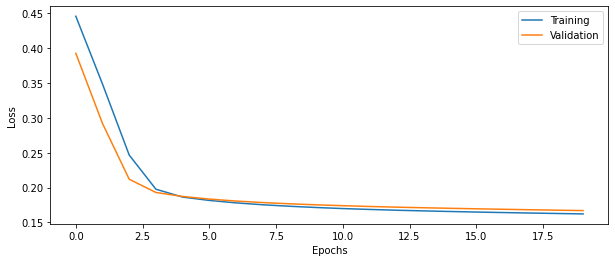

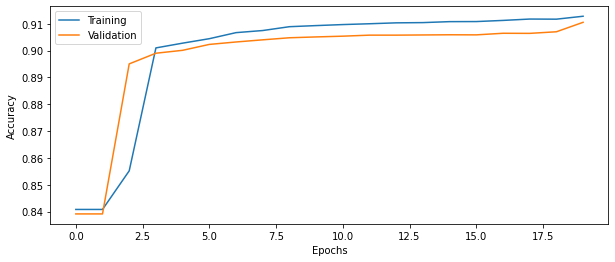

In [20]:
# Plot the history from the training run
plot_results(history1)

# Part 11: More questions

Question 8: What happens if you add several Dense layers without specifying the activation function? 

If adding more Dense layers without activation function, those layers can be expressed by a single dense layer as the output is just the combination of input.

Question 9: How are the weights in each dense layer initialized as default? How are the bias weights initialized?

The weights are initialized through uniform distribution, while the bias weights are initialized as 0.


# Part 12: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

In [21]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(Ytrain), y = Ytrain)

# Print the class weights
print(class_weights)

# Keras wants the weights in this form, uncomment and change value1 and value2 to your weights, 
# or get them from the array that is returned from class_weight

class_weights = {0: class_weights[0],
                1: class_weights[1]}


[3.14112562 0.59465661]


### 2 layers, 20 nodes, class weights

In [64]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model2 = build_DNN(input_shape = input_shape, n_layers = 4, n_nodes=50)

history2 = model2.fit(
                        x=Xtrain,
                        y=Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval),
                        class_weight=class_weights)
model2.summary()

Epoch 1/20
1338/1338 [==============================] - 4s 3ms/step - loss: 0.3180 - accuracy: 0.8230 - val_loss: 0.2749 - val_accuracy: 0.9120
Epoch 2/20
1338/1338 [==============================] - 4s 3ms/step - loss: 0.1664 - accuracy: 0.9161 - val_loss: 0.2384 - val_accuracy: 0.9140
Epoch 3/20
1338/1338 [==============================] - 4s 3ms/step - loss: 0.1651 - accuracy: 0.9158 - val_loss: 0.2773 - val_accuracy: 0.9129
Epoch 4/20
1338/1338 [==============================] - 4s 3ms/step - loss: 0.1640 - accuracy: 0.9164 - val_loss: 0.2178 - val_accuracy: 0.9143
Epoch 5/20
1338/1338 [==============================] - 4s 3ms/step - loss: 0.1593 - accuracy: 0.9180 - val_loss: 0.2259 - val_accuracy: 0.9144
Epoch 6/20
1338/1338 [==============================] - 4s 3ms/step - loss: 0.1572 - accuracy: 0.9185 - val_loss: 0.2041 - val_accuracy: 0.9156
Epoch 7/20
1338/1338 [==============================] - 4s 3ms/step - loss: 0.1554 - accuracy: 0.9185 - val_loss: 0.2261 - val_accuracy:

In [66]:
# Evaluate model on test data
score = model2.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.1752
Test accuracy: 0.9312


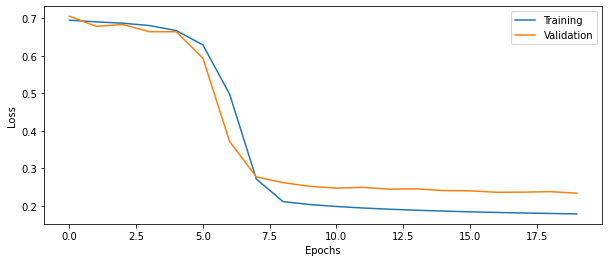

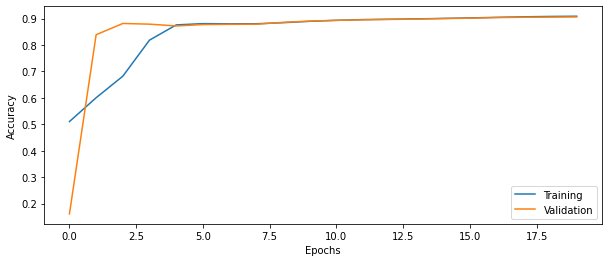

In [24]:
plot_results(history2)

# Part 13: More questions

Skip questions 11 and 12 if you run on the CPU

Question 10: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

10. One reason is that the training data might be too large to store in the memory of CPU and GPU. Another is that large dataset will slow the training proccession as the all data would be scan for each back propagate.

Question 11: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the cloud computer a few times during training.

11. ...

Question 12: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

12. 3-4s for batch_size equals to 100, less than 1s for 1,000 and less than 1s for 10,000. This is because that the running time depends on the number of updates. It equals to total samples/batch_size, which means the larger batch size, the shorter time algorithm would run each epoch.

Question 13: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

13.  As mentioned above, total number of samples/batch_size. Thus, 133742/100=1337 updates for 100 batch size, 138 updates for 1,000 and 14 for 10,000.

Question 14: What limits how large the batch size can be?

14. The space of GPU and CPU, and the running time we require.

Question 15: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

15. Small batch size needs samller learning rate as the gradient is more uncertain, while large batch size should take opposite operation. 

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

# Part 14: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 16: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

16. According to results from model.summary(), there are 2301 parameters for 2 layers and 20 nodes per layer, while there are 12,351 trainable parameters for 4 layers and 50 nodes network.

### 4 layers, 20 nodes, class weights

In [25]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model3 = build_DNN(input_shape = input_shape, n_layers = 4, n_nodes=20)

history3 = model3.fit(
                        x=Xtrain,
                        y=Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval),
                        class_weight=class_weights)

model3.summary()

Epoch 1/20
14/14 [==============================] - 1s 18ms/step - loss: 0.7095 - accuracy: 0.5420 - val_loss: 0.6659 - val_accuracy: 0.8392
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6893 - accuracy: 0.6380 - val_loss: 0.6865 - val_accuracy: 0.8503
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6887 - accuracy: 0.8051 - val_loss: 0.6953 - val_accuracy: 0.1609
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6867 - accuracy: 0.7126 - val_loss: 0.6855 - val_accuracy: 0.8795
Epoch 5/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6852 - accuracy: 0.7650 - val_loss: 0.6660 - val_accuracy: 0.8504
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6754 - accuracy: 0.8764 - val_loss: 0.6675 - val_accuracy: 0.8767
Epoch 7/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6567 - accuracy: 0.8836 - val_loss: 0.6290 - val_accuracy: 0.8794
Epoch 8/20
14/14 [=

In [26]:
# Evaluate model on test data
score = model3.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2233
Test accuracy: 0.9101


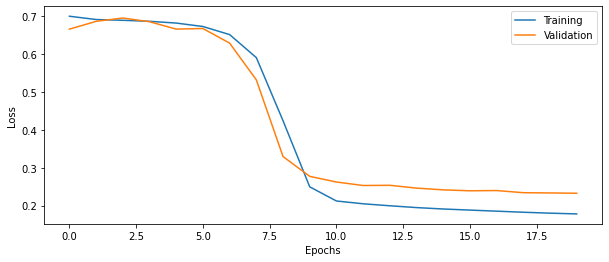

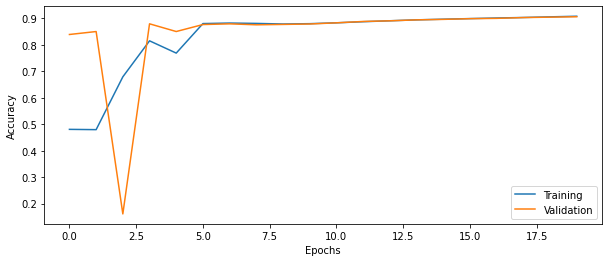

In [27]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [28]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model4 = build_DNN(input_shape = input_shape, n_layers = 2, n_nodes=50)

history4 = model4.fit(
                        x=Xtrain,
                        y=Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval),
                        class_weight=class_weights)

model4.summary()

Epoch 1/20
14/14 [==============================] - 1s 17ms/step - loss: 0.6493 - accuracy: 0.7004 - val_loss: 0.4475 - val_accuracy: 0.8817
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.3487 - accuracy: 0.8846 - val_loss: 0.2835 - val_accuracy: 0.8832
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 0.2143 - accuracy: 0.8881 - val_loss: 0.2609 - val_accuracy: 0.8914
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.2001 - accuracy: 0.8940 - val_loss: 0.2554 - val_accuracy: 0.8942
Epoch 5/20
14/14 [==============================] - 0s 9ms/step - loss: 0.1934 - accuracy: 0.8974 - val_loss: 0.2504 - val_accuracy: 0.8956
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.1909 - accuracy: 0.8968 - val_loss: 0.2450 - val_accuracy: 0.8967
Epoch 7/20
14/14 [==============================] - 0s 9ms/step - loss: 0.1898 - accuracy: 0.8979 - val_loss: 0.2423 - val_accuracy: 0.8982
Epoch 8/20
14/14 [=

In [29]:
# Evaluate model on test data
score = model4.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2212
Test accuracy: 0.9111


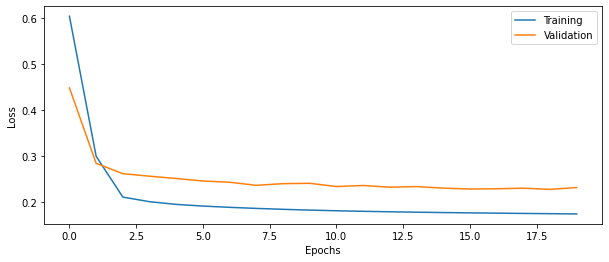

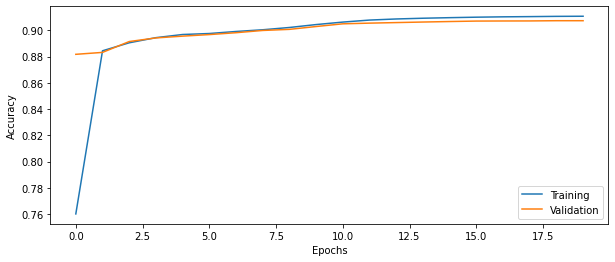

In [30]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [31]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model5 = build_DNN(input_shape = input_shape, n_layers = 4, n_nodes=50)

history5 = model5.fit(
                        x=Xtrain,
                        y=Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval),
                        class_weight=class_weights)
model5.summary()


Epoch 1/20
14/14 [==============================] - 1s 19ms/step - loss: 0.7444 - accuracy: 0.4814 - val_loss: 0.6758 - val_accuracy: 0.8392
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6922 - accuracy: 0.6675 - val_loss: 0.6840 - val_accuracy: 0.8549
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6885 - accuracy: 0.7541 - val_loss: 0.6835 - val_accuracy: 0.8936
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6822 - accuracy: 0.7946 - val_loss: 0.6686 - val_accuracy: 0.8969
Epoch 5/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6663 - accuracy: 0.8938 - val_loss: 0.6512 - val_accuracy: 0.8833
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6301 - accuracy: 0.8892 - val_loss: 0.5709 - val_accuracy: 0.8813
Epoch 7/20
14/14 [==============================] - 0s 8ms/step - loss: 0.5070 - accuracy: 0.8849 - val_loss: 0.3337 - val_accuracy: 0.8844
Epoch 8/20
14/14 [=

In [32]:
# Evaluate model on test data
score = model5.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2273
Test accuracy: 0.9101


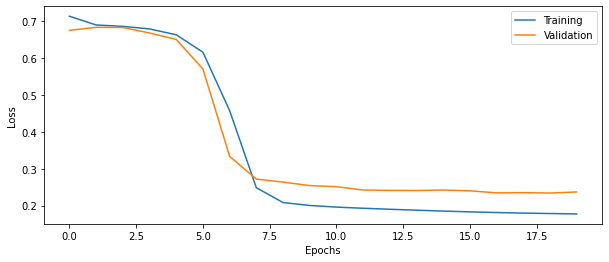

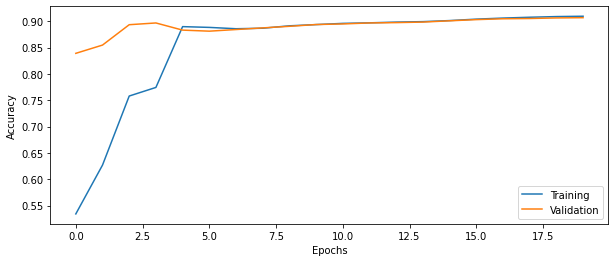

In [33]:
plot_results(history5)

# Part 15: Batch normalization

Now add batch normalization after each dense layer in `build_DNN`. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 17: Why is batch normalization important when training deep networks?

17. Some dimensions may have high variance and some may be low. batch normalization can may the samples isotropic, making optimization easier.

### 2 layers, 20 nodes, class weights, batch normalization

In [34]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.optimizers import SGD
from keras.losses import categorical_crossentropy
from keras.layers import BatchNormalization

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

# Setup some training parameters
batch_size = 10000
epochs = 60
input_shape = Xtrain.shape

# Build and train model

model6 = build_DNN(input_shape = input_shape, n_layers = 2, n_nodes=20,use_bn = True)

history6 = model6.fit(
                        x=Xtrain,
                        y=Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval),
                        class_weight=class_weights)

model6.summary()

Epoch 1/60
14/14 [==============================] - 1s 21ms/step - loss: 0.5849 - accuracy: 0.5238 - val_loss: 0.4229 - val_accuracy: 0.8935
Epoch 2/60
14/14 [==============================] - 0s 9ms/step - loss: 0.2358 - accuracy: 0.8847 - val_loss: 0.2555 - val_accuracy: 0.9045
Epoch 3/60
14/14 [==============================] - 0s 9ms/step - loss: 0.1995 - accuracy: 0.8980 - val_loss: 0.2194 - val_accuracy: 0.9100
Epoch 4/60
14/14 [==============================] - 0s 9ms/step - loss: 0.1883 - accuracy: 0.9046 - val_loss: 0.2045 - val_accuracy: 0.9025
Epoch 5/60
14/14 [==============================] - 0s 9ms/step - loss: 0.1849 - accuracy: 0.9074 - val_loss: 0.1964 - val_accuracy: 0.9027
Epoch 6/60
14/14 [==============================] - 0s 9ms/step - loss: 0.1808 - accuracy: 0.9097 - val_loss: 0.1908 - val_accuracy: 0.9030
Epoch 7/60
14/14 [==============================] - 0s 9ms/step - loss: 0.1803 - accuracy: 0.9088 - val_loss: 0.1869 - val_accuracy: 0.9055
Epoch 8/60
14/14 [=

In [35]:
# Evaluate model on test data
score = model6.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.1761
Test accuracy: 0.9186


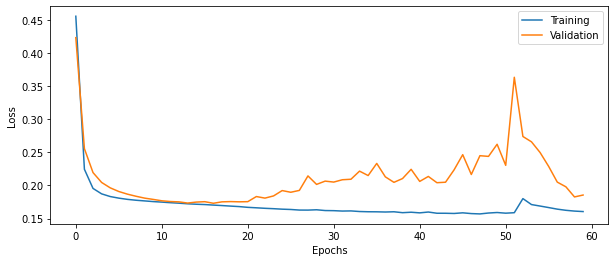

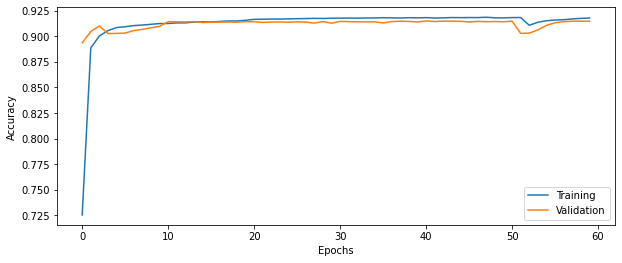

In [36]:
plot_results(history6)

# Part 16: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

https://keras.io/api/layers/activations/

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [37]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model7 = build_DNN(input_shape = input_shape, n_layers = 2, n_nodes=20,act_fun ='relu')

history7 = model7.fit(
                        x=Xtrain,
                        y=Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval),
                        class_weight=class_weights)

model7.summary()

Epoch 1/20
14/14 [==============================] - 1s 18ms/step - loss: 1.3841 - accuracy: 0.7163 - val_loss: 2.4550 - val_accuracy: 0.8390
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 7.6268 - accuracy: 0.8406 - val_loss: 2.4528 - val_accuracy: 0.8392
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 7.5692 - accuracy: 0.8420 - val_loss: 2.4528 - val_accuracy: 0.8392
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 7.6606 - accuracy: 0.8401 - val_loss: 2.4528 - val_accuracy: 0.8392
Epoch 5/20
14/14 [==============================] - 0s 8ms/step - loss: 7.6064 - accuracy: 0.8412 - val_loss: 2.4528 - val_accuracy: 0.8392
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 7.5978 - accuracy: 0.8414 - val_loss: 2.4528 - val_accuracy: 0.8392
Epoch 7/20
14/14 [==============================] - 0s 8ms/step - loss: 7.6096 - accuracy: 0.8411 - val_loss: 2.4528 - val_accuracy: 0.8392
Epoch 8/20
14/14 [=

In [38]:
# Evaluate model on test data
score = model7.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 2.4005
Test accuracy: 0.8426


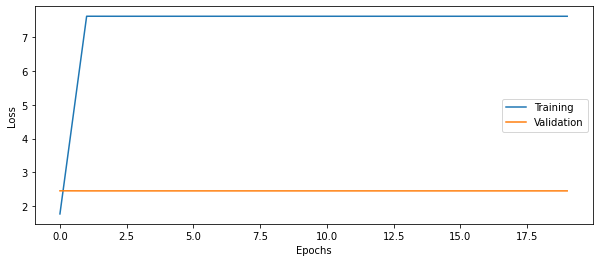

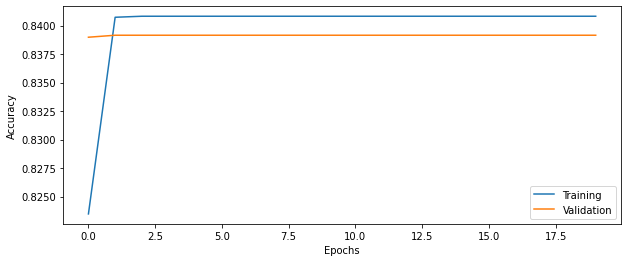

In [39]:
plot_results(history7)

# Part 17: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [40]:
from keras.optimizers import Adam
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model8 = build_DNN(input_shape = input_shape, n_layers = 2, n_nodes=20,optimizer='Adam')

history8 = model8.fit(
                        x=Xtrain,
                        y=Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval),
                        class_weight=class_weights)

model8.summary()

Epoch 1/20
14/14 [==============================] - 1s 19ms/step - loss: 0.4233 - accuracy: 0.7284 - val_loss: 0.2657 - val_accuracy: 0.8887
Epoch 2/20
14/14 [==============================] - 0s 9ms/step - loss: 0.1917 - accuracy: 0.8958 - val_loss: 0.2317 - val_accuracy: 0.9088
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 0.1758 - accuracy: 0.9105 - val_loss: 0.2285 - val_accuracy: 0.9113
Epoch 4/20
14/14 [==============================] - 0s 9ms/step - loss: 0.1694 - accuracy: 0.9147 - val_loss: 0.2310 - val_accuracy: 0.9129
Epoch 5/20
14/14 [==============================] - 0s 9ms/step - loss: 0.1682 - accuracy: 0.9146 - val_loss: 0.2216 - val_accuracy: 0.9131
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.1649 - accuracy: 0.9158 - val_loss: 0.2157 - val_accuracy: 0.9135
Epoch 7/20
14/14 [==============================] - 0s 8ms/step - loss: 0.1644 - accuracy: 0.9159 - val_loss: 0.2014 - val_accuracy: 0.9144
Epoch 8/20
14/14 [=

In [41]:
# Evaluate model on test data
score = model8.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2018
Test accuracy: 0.9217


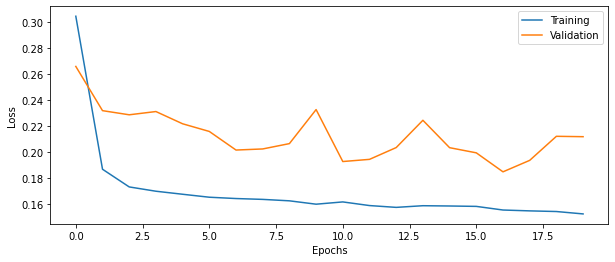

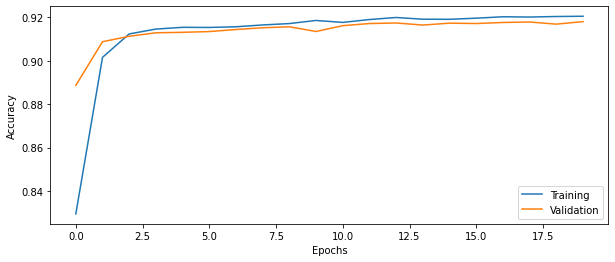

In [42]:
plot_results(history8)

# Part 18: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. 

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/api/layers/regularization_layers/dropout/ for how the Dropout layer works.

---

Question 18: How does the validation accuracy change when adding dropout?

18.  The validation accuracy is more close to training accuracy after adding dropout, whicn means overfitting is less significant compared to network without dropout.

Question 19: How does the test accuracy change when adding dropout?

19. The test accuracy seems to be slightly lower as there are more uncertainty in the network.

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [43]:
from keras.layers import Dropout
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

def build_DNN_drop(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    sgd = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)

    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function

    # Add first layer, requires input shape
    model.add(Dense(n_nodes ,activation=act_fun, input_dim=input_shape[1]))
    model.add(Dropout(0.2))
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add (Dense(n_nodes,activation=act_fun))
        model.add(Dropout(0.2))
    # Final layer
    model.add (Dense(1,activation=act_fun))
    
    # Compile model
    model.compile(optimizer=sgd,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Build and train model
model9 = build_DNN_drop(input_shape = input_shape, n_layers = 2, n_nodes=20)

history9 = model9.fit(
                        x=Xtrain,
                        y=Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval),
                        class_weight=class_weights)


model9.summary()

Epoch 1/20
14/14 [==============================] - 1s 17ms/step - loss: 0.7282 - accuracy: 0.4493 - val_loss: 0.5875 - val_accuracy: 0.8761
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.4920 - accuracy: 0.7941 - val_loss: 0.3219 - val_accuracy: 0.8782
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 0.2875 - accuracy: 0.8787 - val_loss: 0.2897 - val_accuracy: 0.8782
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.2467 - accuracy: 0.8824 - val_loss: 0.2822 - val_accuracy: 0.8803
Epoch 5/20
14/14 [==============================] - 0s 8ms/step - loss: 0.2390 - accuracy: 0.8831 - val_loss: 0.2774 - val_accuracy: 0.8844
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.2308 - accuracy: 0.8870 - val_loss: 0.2707 - val_accuracy: 0.8889
Epoch 7/20
14/14 [==============================] - 0s 8ms/step - loss: 0.2261 - accuracy: 0.8893 - val_loss: 0.2664 - val_accuracy: 0.8927
Epoch 8/20
14/14 [=

In [44]:
# Evaluate model on test data
score = model9.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2356
Test accuracy: 0.9058


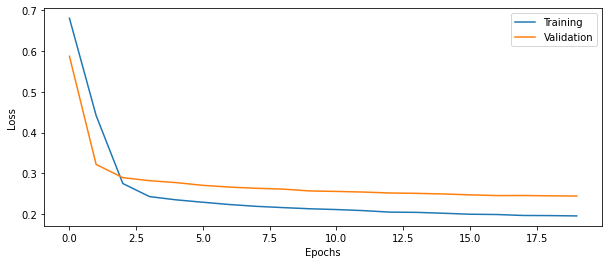

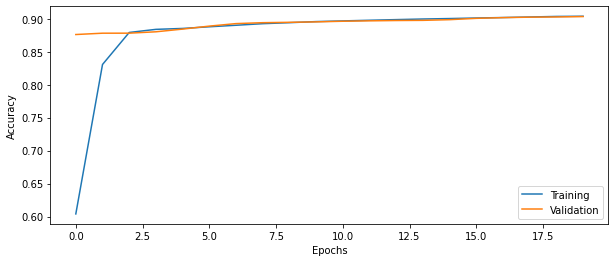

In [45]:
plot_results(history9)

# Part 19: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 20: How high classification accuracy can you achieve for the test data? What is your best configuration?

For test data set , the accuracy is 91.45%.


Configuration:
    number of middle layers : 5; number of nodes in each layer: 70; optimizer: Adam; use batch normalization; use dropout.


In [60]:
# Find your best configuration for the DNN
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.layers import BatchNormalization

# Setup some training parameters
batch_size = 500
epochs = 30
input_shape = Xtrain.shape

# Build and train model
model10 = build_DNN(input_shape = input_shape, n_layers = 5, n_nodes=70,optimizer='Adam',use_bn=True, use_dropout=True)

history10 = model10.fit(
                        x=Xtrain,
                        y=Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval),
                        class_weight=class_weights)

model10.summary()



Epoch 1/30
268/268 [==============================] - 3s 7ms/step - loss: 0.2510 - accuracy: 0.8743 - val_loss: 0.2577 - val_accuracy: 0.9035
Epoch 2/30
268/268 [==============================] - 2s 6ms/step - loss: 0.1781 - accuracy: 0.9103 - val_loss: 0.2208 - val_accuracy: 0.9124
Epoch 3/30
268/268 [==============================] - 2s 6ms/step - loss: 0.1745 - accuracy: 0.9119 - val_loss: 0.2223 - val_accuracy: 0.9121
Epoch 4/30
268/268 [==============================] - 2s 6ms/step - loss: 0.1722 - accuracy: 0.9135 - val_loss: 0.2285 - val_accuracy: 0.9130
Epoch 5/30
268/268 [==============================] - 2s 6ms/step - loss: 0.1721 - accuracy: 0.9141 - val_loss: 0.2228 - val_accuracy: 0.9131
Epoch 6/30
268/268 [==============================] - 2s 6ms/step - loss: 0.1720 - accuracy: 0.9140 - val_loss: 0.2273 - val_accuracy: 0.9131
Epoch 7/30
268/268 [==============================] - 2s 6ms/step - loss: 0.1727 - accuracy: 0.9133 - val_loss: 0.2393 - val_accuracy: 0.9027
Epoch 

In [47]:
# Evaluate DNN on test data
score = model10.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2423
Test accuracy: 0.9145


# Part 20: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN. The `build_DNN` function takes two boolean arguments, use_dropout and use_custom_dropout, add a standard Dropout layer if use_dropout is true, add a myDropout layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 21: What is the mean and the standard deviation of the test accuracy?

The mean of accuracy is 93.4%, while the standard deviation is too small that the result is 0.

In [48]:
import keras.backend as K
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [62]:
# Your best training parameters
batch_size = 500
epochs = 30
input_shape = Xtrain.shape
lr=0.1

# Build and train model
model11 = build_DNN(input_shape = input_shape, n_layers = 5, n_nodes=70,optimizer='sgd',learning_rate=lr,use_bn=True, use_custom_dropout=True)

history11 = model11.fit(
                        x=Xtrain,
                        y=Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval),
                        class_weight=class_weights)


model11.summary()

Epoch 1/30
268/268 [==============================] - 3s 7ms/step - loss: 0.2084 - accuracy: 0.8908 - val_loss: 0.1946 - val_accuracy: 0.8676
Epoch 2/30
268/268 [==============================] - 2s 6ms/step - loss: 0.1667 - accuracy: 0.9155 - val_loss: 0.2432 - val_accuracy: 0.9107
Epoch 3/30
268/268 [==============================] - 2s 6ms/step - loss: 0.1615 - accuracy: 0.9168 - val_loss: 0.2308 - val_accuracy: 0.9141
Epoch 4/30
268/268 [==============================] - 2s 6ms/step - loss: 0.1591 - accuracy: 0.9176 - val_loss: 0.2107 - val_accuracy: 0.9184
Epoch 5/30
268/268 [==============================] - 2s 6ms/step - loss: 0.1584 - accuracy: 0.9185 - val_loss: 0.2081 - val_accuracy: 0.9145
Epoch 6/30
268/268 [==============================] - 2s 6ms/step - loss: 0.1546 - accuracy: 0.9195 - val_loss: 0.1882 - val_accuracy: 0.9157
Epoch 7/30
268/268 [==============================] - 2s 6ms/step - loss: 0.1502 - accuracy: 0.9222 - val_loss: 0.1952 - val_accuracy: 0.9158
Epoch 

In [63]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(Xtest, Ytest, verbose=0)
                       
print('Test accuracy: %.4f' % score[1])

Test accuracy: 0.9342


In [59]:
# Run the testing 100 times, and save the accuracies in an array
batch_size = 10000
epochs = 20

accuracy= np.array(np.arange(0,100), np.float32)
i=0
for j in range(100):
    model13=build_DNN(input_shape = input_shape, n_layers = 2, n_nodes=20,use_custom_dropout=True)
    # Fit the model with training set and class weights for this fold
    model13.fit(
                        x=Xtrain,
                        y=Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval),
                        class_weight=class_weights)
    # Evaluate the model using the test set for this fold
    score = model11.evaluate(Xtest, Ytest, verbose=0)
    accuracy[i] = score[1]
    i=i+1
# Calculate and print mean and std of accuracies
mean_v = np.mean(accuracy)
std_v = np.std(accuracy)

print('The mean of cross validation is %.4f'% mean_v)
print('The standard deviation of cross validation is %.4f'% std_v)



Epoch 1/20
14/14 [==============================] - 1s 20ms/step - loss: 0.6694 - accuracy: 0.8592 - val_loss: 0.5375 - val_accuracy: 0.8817
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.4654 - accuracy: 0.8833 - val_loss: 0.3064 - val_accuracy: 0.8786
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 0.2429 - accuracy: 0.8813 - val_loss: 0.2716 - val_accuracy: 0.8815
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.2100 - accuracy: 0.8854 - val_loss: 0.2589 - val_accuracy: 0.8885
Epoch 5/20
14/14 [==============================] - 0s 8ms/step - loss: 0.2021 - accuracy: 0.8906 - val_loss: 0.2530 - val_accuracy: 0.8917
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.1976 - accuracy: 0.8941 - val_loss: 0.2474 - val_accuracy: 0.8944
Epoch 7/20
14/14 [==============================] - 0s 8ms/step - loss: 0.1934 - accuracy: 0.8969 - val_loss: 0.2450 - val_accuracy: 0.8959
Epoch 8/20
14/14 [=

In [58]:
range(10)

range(0, 10)

# Part 21: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 22: What is the mean and the standard deviation of the test accuracy?

22. the mean od test accracy is 93.1%, with very little standard deviation.

Question 23: What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.

23. Dropout makes use of the full data, while the CV only use part of the dataset, and these parts may not represent the character of the original data, when the data set is super large.


In [55]:
from sklearn.model_selection import StratifiedKFold
import random
batch_size = 10000
epochs = 20

accuracy= np.array(np.arange(0,10), np.float32)
i=0
# random.seed(1234)
# Define 10-fold cross validation
skf = StratifiedKFold(n_splits=10)
# Loop over cross validation folds
for train_index, test_index in skf.split(Xtrain, Ytrain):

    # Calculate class weights for current split
    X_train, X_test = Xtrain[train_index], Xtrain[test_index]
    y_train, y_test = Ytrain[train_index], Ytrain[test_index]
    class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
    class_weights = {0: class_weights[0],
                    1: class_weights[1]}
    input_shape = X_train.shape
    # Rebuild the DNN model, to not continue training on the previously trained model
    model12=build_DNN(input_shape = input_shape, n_layers = 2, n_nodes=20,use_custom_dropout=True)
    # Fit the model with training set and class weights for this fold
    model12.fit(
                        x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_test,y_test),
                        class_weight=class_weights)
    # Evaluate the model using the test set for this fold
    score = model11.evaluate(Xtest, Ytest, verbose=0)
    # Save the test accuracy in an array
    accuracy[i] = score[1]
    i=i+1
# Calculate and print mean and std of accuracies
mean_v = np.mean(accuracy)
std_v = np.std(accuracy)

print('The mean of cross validation is %.4f'% mean_v)
print('The standard deviation of cross validation is %.4f'% std_v)


Epoch 1/20
13/13 [==============================] - 1s 18ms/step - loss: 0.6868 - accuracy: 0.6549 - val_loss: 0.5370 - val_accuracy: 0.8964
Epoch 2/20
13/13 [==============================] - 0s 8ms/step - loss: 0.5114 - accuracy: 0.8872 - val_loss: 0.3359 - val_accuracy: 0.8799
Epoch 3/20
13/13 [==============================] - 0s 8ms/step - loss: 0.2753 - accuracy: 0.8779 - val_loss: 0.2733 - val_accuracy: 0.8824
Epoch 4/20
13/13 [==============================] - 0s 8ms/step - loss: 0.2155 - accuracy: 0.8810 - val_loss: 0.2519 - val_accuracy: 0.8870
Epoch 5/20
13/13 [==============================] - 0s 8ms/step - loss: 0.2075 - accuracy: 0.8845 - val_loss: 0.2458 - val_accuracy: 0.8902
Epoch 6/20
13/13 [==============================] - 0s 8ms/step - loss: 0.2022 - accuracy: 0.8895 - val_loss: 0.2404 - val_accuracy: 0.8951
Epoch 7/20
13/13 [==============================] - 0s 8ms/step - loss: 0.1986 - accuracy: 0.8926 - val_loss: 0.2366 - val_accuracy: 0.8991
Epoch 8/20
13/13 [=

# Part 22: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 24: How would you change the DNN in order to use it for regression instead?

24. Set the input as independent variable, and set data we want without activation function in the output layer(n dimensions).

## Report

Send in this jupyter notebook, with answers to all questions.